# Part B: Regression

**<font size=4>
Prediction Task**

**How is your prediction task defined?**

- We are given a dataset containing housing prices in the US with other attributes such as city, house area, renovation status, etc.
- The prediction task is to create a predicive regression model to predict the housing prices based of these attributes

**What is the meaning of the output variable?**

- The output variable is Price($)
- This is how much the house is sold at in dollars ($)
- As the output variable is a continuous (numerical) variable, we reuire a regression model


# Background Research

Incomplete

# References

* scikit link...
* pearson r link...
* background research link...
* dataset source

# Importing Libraries

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
sns.set()


# Experimental
from sklearn.experimental import enable_halving_search_cv, enable_hist_gradient_boosting

# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve
from statsmodels.api import qqplot
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PolynomialFeatures, OneHotEncoder, PowerTransformer
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import LinearSVR

# Hyperparameter Tuning
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV, validation_curve, RandomizedSearchCV


# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, SequentialFeatureSelector, VarianceThreshold, mutual_info_regression, RFE

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
# random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

# Defining Utitlity Functions

Functions that wil be used

- Plot learning curve
- Plot validation curve
- Plot outliers
- Countplot

In [4]:

def plot_learning_curve(model, X, y, scoring, cv = KFold(shuffle=True, random_state = 42), train_sizes = np.linspace(.1, 1.0, 5)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=scoring)
  scores = pd.DataFrame({
      "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve of {model_name}")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel("Train Sizes")
  return fig

def plot_validation_curve(model, X, y, param_name, param_range, scoring="neg_mean_absolute_error", cv=KFold(shuffle=True, random_state = 42)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_scores, test_scores = validation_curve(model, X, y, param_name = param_name, param_range = param_range, scoring=scoring, n_jobs = -1)
  scores = pd.DataFrame({
      "Param Range" : np.tile(param_range, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Param Range"])
  
  sns.lineplot(data=scores, x="Param Range", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Validation Curve of {model_name} ({param_name})")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel(f"{param_name}")
  return fig

def outlierDetection(df, var, sort = True, deskew=True):
    """
    Utilty function for detecting basic outliers. Prints out no. of outliers, shows first 5 outliers and displays a box plot. Outliers are defined in this case by Tukey's fences, where outliers are data points above or below the upper or lower quantiles by 1.5 * IQR.

    Parameters:
        df = DataFrame to detect outliers in
        var = name of column where outlier detection is performed
        sort = should the returned dataset be sorted?
    Returns:
        Dataset which only includes outliers
    """
    if deskew:
      col = df[var].apply(np.log)
    else:
      col = df[var]
    Q3 = col.quantile(0.75)
    Q1 = col.quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (col > UpperFence) | (col < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("Outliers in Series (First 5)")
        display(outlier_df.head())
        print("No. of Outliers:", len(outlier_df))
    sns.boxplot(y = var,data = df, orient= "h")
    sns.despine(left = True)
    plt.title(f"Box Plot of {var}")
    plt.show()
    if sort:
        return outlier_df.sort_values(var)
    else:
        return outlier_df


def cat_plot(df, features, figsize = (10, 20)):
    fig, ax = plt.subplots(len(features), 1, figsize= figsize, tight_layout = True)
    for idx, feature in enumerate(features):
        ax[idx].set_title("Counts of " + feature)
        # counts = df[feature].value_counts()
        sns.countplot(data = df, y = feature, ax = ax[idx])
    return fig

# Data Exploration

* Conduct an exploratory data analysis of the data, to gain a better understanding of the characteristics of the dataset.
* To prevent the mutation of original data, I will make a copy to perform EDA on it
* The data set is constructed from the housing infromation of 545 houses in the US

**Objectives for EDA**
- How many rows and how many columns are there
- Distribution of the target variable (Price ($))
- Distribution of the columns in our dataset
- Missing values present
- Outliers present
- Correlation between variables 
- Corerlation between variables and target variable (Price ($))

**Metadata**
* House ID: Unique house identifier ranging from 0 to 544
* City: Which city the house is located
* House Area: Size of the house in square meters
* No. of Bedrooms: How many bedrooms in the house
* No. of Toilets: How many toilets in the house
* Stories: The number of stories in the house
* Renovation Status: How well the house is renovated
* Price: The price of the house in US dollars

In [6]:
# Import the dataset
housing_df = pd.read_csv('../../datasets/housing_dataset.csv')
housing_df

,House ID,City,House Area (sqm),No. of Bedrooms,No. of Toilets,Stories,Renovation Status,Price ($)
0,0,Chicago,742.0,4,2,3,furnished,1330000
1,1,Denver,896.0,4,4,4,furnished,1225000
2,2,Chicago,996.0,3,2,2,semi-furnished,1225000
3,3,Seattle,750.0,4,2,2,furnished,1221500
4,4,New York,742.0,4,1,2,furnished,1141000
...,...,...,...,...,...,...,...,...
540,540,Seattle,300.0,2,1,1,unfurnished,182000
541,541,New York,240.0,3,1,1,semi-furnished,176715
542,542,Boston,362.0,2,1,1,unfurnished,175000
543,543,Seattle,291.0,3,1,1,furnished,175000


In [7]:
housing_eda = housing_df.copy()

# Descriptive Analysis

In [8]:
housing_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   House ID           545 non-null    int64  
 1   City               545 non-null    object 
 2   House Area (sqm)   545 non-null    float64
 3   No. of Bedrooms    545 non-null    int64  
 4   No. of Toilets     545 non-null    int64  
 5   Stories            545 non-null    int64  
 6   Renovation Status  545 non-null    object 
 7   Price ($)          545 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 34.2+ KB


- There are 545 rows and 8 columns in this dataset
- There appears to be no missing values in the dataset
- House ID contain identifiers for each house
- As this value does not provide any insight to my analysis, it would be best to drop this column


In [10]:
descriptive_stats = housing_eda.describe().T
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
House ID,545.0,272.000000,157.472220,0.0,136.0,272.0,408.0,544.0
House Area (sqm),545.0,515.054128,217.014102,165.0,360.0,460.0,636.0,1620.0
No. of Bedrooms,545.0,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
No. of Toilets,545.0,1.286239,0.502470,1.0,1.0,1.0,2.0,4.0
Stories,545.0,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
Price ($),545.0,476672.924771,187043.961566,175000.0,343000.0,434000.0,574000.0,1330000.0


- House Area (sqm) is likely to be postively skewed with outliers as the max area is larger than the upper quartile (75%)
- Similarly, Price($) is likely to be positively skewed as well, becuase the max housing price is much larger compared to the upper quartile (75%)
- House Area (sqm) and Price ($) are both continuous variables 
- Apart from that, No. of Bedrooms, No. of Toilets and Stories are all discrete variables

# Univariate Analysis

**Target Variable Distribution: Price($)**

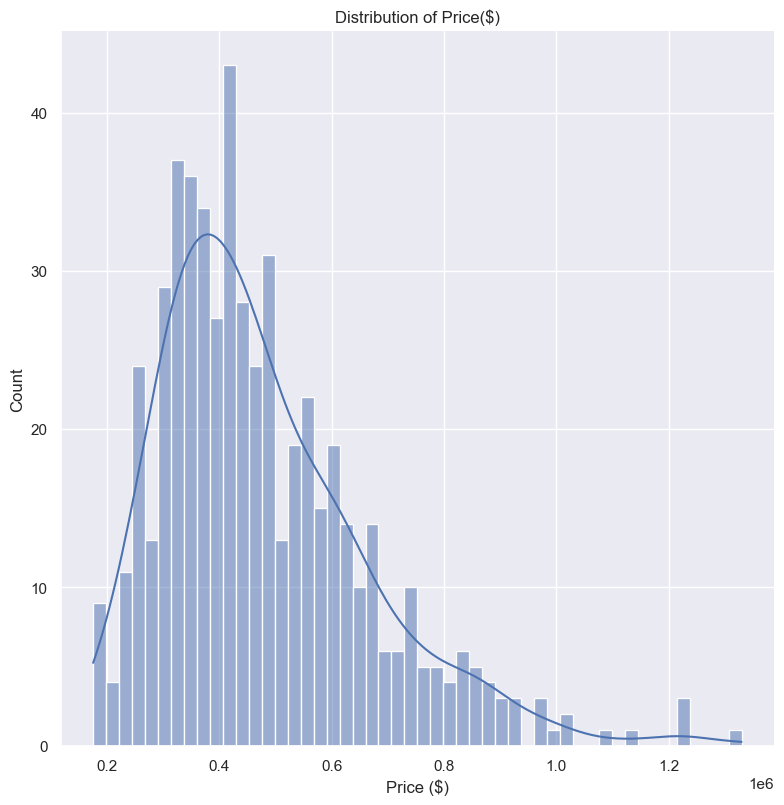

In [28]:

sns.displot(data=housing_eda, x="Price ($)", kde=True, bins=50, height=8)
plt.title("Distribution of Price($)")
plt.show()
     

- The distribution of Price ($) is positvely skewed
- Most houses are less than $700K USD, but some house can cost up to over $1.2M USD
- Let's try to deskew it using a log scaler

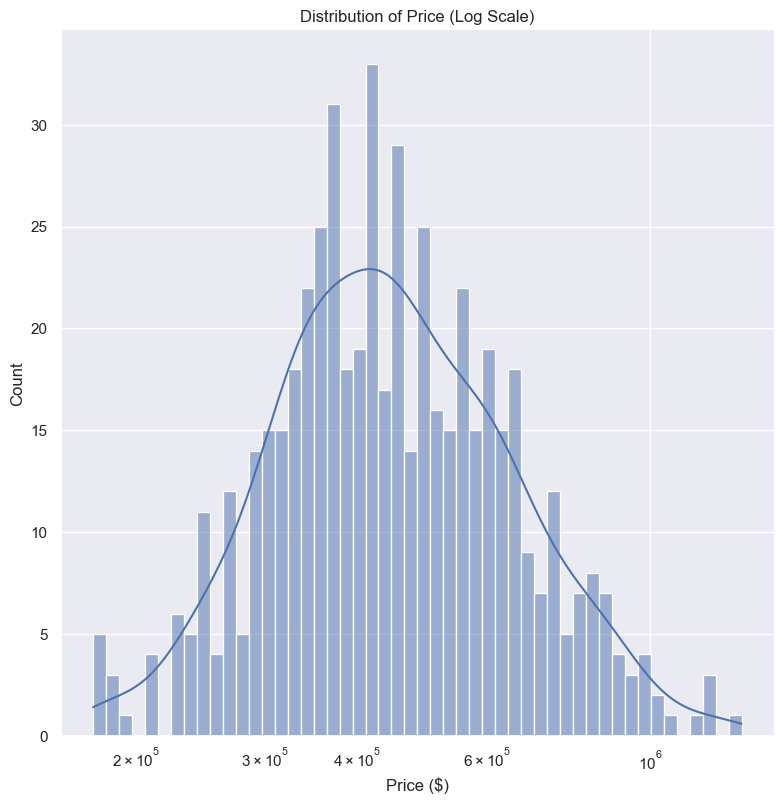

In [27]:
sns.displot(data=housing_eda, x="Price ($)", kde=True, log_scale=True, bins=50, height = 8)
plt.title("Distribution of Price (Log Scale)")
plt.show()

- After performing log scaling, the prices seem to follow a normal distribution
- Suggests that the prices of these houses follow a log normla distribution
- (Log) Transformation of the target variable may improve the performance of the model 

**Discrete Variables**

<Axes: xlabel='No. of Bedrooms', ylabel='Count'>

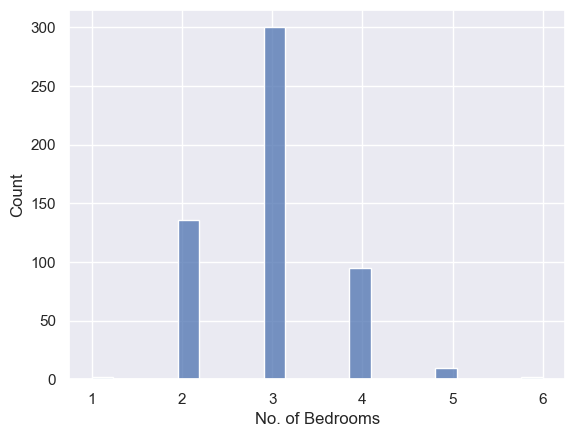

In [32]:
discrete_features = ['No. of Bedrooms', 'No. of Toilets', 'Stories']
# housing_eda[discrete_features].hist(figsize=(8, 8))
# plt.tight_layout()
# plt.show()
sns.histplot(x='No. of Bedrooms', data=housing_eda)

# Bivariate Analysis

# Missing Values Analysis (Check if we need imputation)

# Data Preprocessing